In [1]:
!pip install ydata-profiling
#!pip install flaml[notebook]

  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
momepy 0.6.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
pymc3 3.11.5 requires numpy<1.22.2,>=1.15.0, but you have numpy 1.23.5 which is incompatible.
pymc3 3.11.5 requires scipy<1.8.0,>=1.7.3, but you have scipy 1.9.3 which is incompatible.


# ✨ Importing necesssary modules

In [2]:
import gc
import warnings
import numpy as np 
import pandas as pd 
from math import ceil, sqrt
import lightgbm as lgb
warnings.filterwarnings('ignore')
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from ydata_profiling import ProfileReport
#from ydata_profiling import ProfileReport
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, OneHotEncoder
from category_encoders.binary import BinaryEncoder
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbpipeline 
import seaborn as sns
import matplotlib.pyplot as plt
import statistics
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB 
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
import lightgbm as lgb
from lightgbm import LGBMClassifier


# 📖 Read the data into a dataframe

In [3]:
df = pd.read_csv("../input/credit-card-transactions/credit_card_transactions-ibm_v2.csv",
                 dtype = {'Year' : 'int16', 'Month' : 'int8', 'Day' : 'int8',
                           'Use Chip' : 'category', 'MCC' : 'int16', 'Is Fraud?' : 'category' , 
                            'Merchant City' : 'category', 'Amount' : 'string'})
df.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,No
1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
2,0,0,2002,9,2,06:22,$120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
3,0,0,2002,9,2,17:45,$128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,NaN,No
4,0,0,2002,9,3,06:23,$104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,No


# 📊 EDA

In [11]:
profile = ProfileReport(df, title = "Data Report", explorative = True, minimal = True, dark_mode=True )
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
profile.to_notebook_iframe()

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24386900 entries, 0 to 24386899
Data columns (total 15 columns):
 #   Column          Dtype   
---  ------          -----   
 0   User            int64   
 1   Card            int64   
 2   Year            int16   
 3   Month           int8    
 4   Day             int8    
 5   Time            object  
 6   Amount          string  
 7   Use Chip        category
 8   Merchant Name   int64   
 9   Merchant City   category
 10  Merchant State  object  
 11  Zip             float64 
 12  MCC             int16   
 13  Errors?         object  
 14  Is Fraud?       category
dtypes: category(3), float64(1), int16(2), int64(3), int8(2), object(3), string(1)
memory usage: 1.7+ GB


In [5]:
df.describe()

,User,Card,Year,Month,Day,Merchant Name,Zip,MCC
count,2.438690e+07,2.438690e+07,2.438690e+07,2.438690e+07,2.438690e+07,2.438690e+07,2.150876e+07,2.438690e+07
mean,1.001019e+03,1.351366e+00,2.011955e+03,6.525064e+00,1.571812e+01,-4.769230e+17,5.095644e+04,5.561171e+03
std,5.694612e+02,1.407154e+00,5.105921e+00,3.472355e+00,8.794073e+00,4.758940e+18,2.939707e+04,8.793154e+02
min,0.000000e+00,0.000000e+00,1.991000e+03,1.000000e+00,1.000000e+00,-9.222899e+18,5.010000e+02,1.711000e+03
25%,5.100000e+02,0.000000e+00,2.008000e+03,3.000000e+00,8.000000e+00,-4.500543e+18,2.837400e+04,5.300000e+03
50%,1.006000e+03,1.000000e+00,2.013000e+03,7.000000e+00,1.600000e+01,-7.946765e+17,4.674200e+04,5.499000e+03
75%,1.477000e+03,2.000000e+00,2.016000e+03,1.000000e+01,2.300000e+01,3.189517e+18,7.756400e+04,5.812000e+03
max,1.999000e+03,8.000000e+00,2.020000e+03,1.200000e+01,3.100000e+01,9.223292e+18,9.992800e+04,9.402000e+03


In [34]:
print(f"Missing values in 'Errors?' column: {df['Errors?'].isna().sum()}")

Missing values in 'Errors?' column: 23998469


<Axes: >

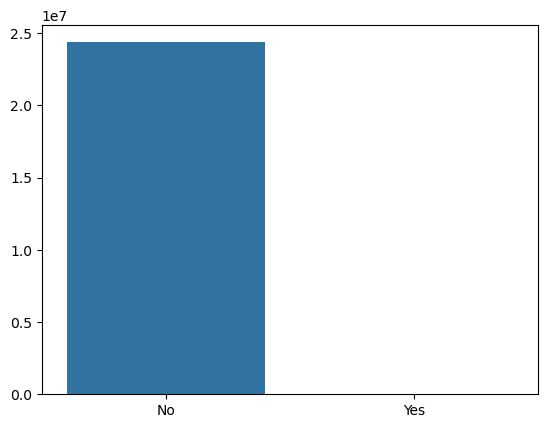

In [32]:
value_counts = df['Is Fraud?'].value_counts()
sns.barplot(x=value_counts.index, y=value_counts.values)

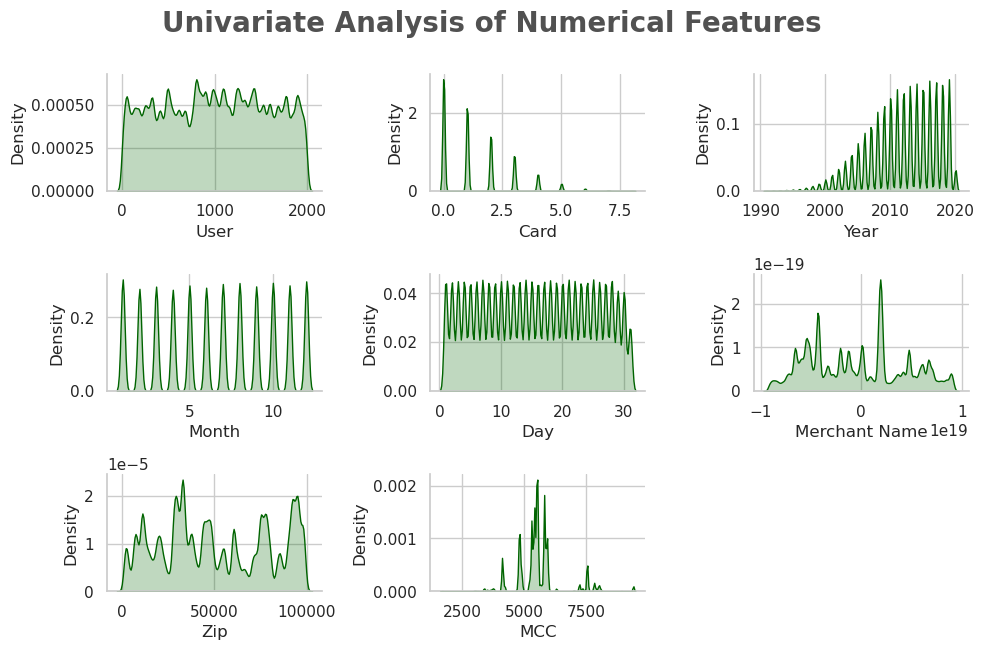

In [16]:
numeric_features = ['User', 'Card', 'Year', 'Month' , 'Day', 'Merchant Name', 'Zip' , 'MCC']

plt.figure(figsize = (10,10))
plt.suptitle('Univariate Analysis of Numerical Features', fontsize = 20, fontweight = 'bold', alpha = 0.8, y = 1)

for i in range(0, len(numeric_features)):
    plt.subplot(5,3, i+1)
    sns.kdeplot(x = df[numeric_features[i]], shade = True, color = 'darkgreen')
    sns.despine()
    plt.xlabel(numeric_features[i])
    plt.tight_layout()

## Observations: 
**Number of variables** : 15

**Number of observations** : 24386900 (24.3M)

**Missing cells** : 29597425

**Missing cells (%)** : 8.1%

**Total size in memory** : 5.8 G

**Numerical** : 8 

**Categorical** : 7

Large number of missing values in **Errors?** column.

**Is Fraud?** column is highly imbalanced.

No column follows normal distribution.

Data contains irregularities.

# 🪓 Train Test Split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Is Fraud?'],axis=1), df['Is Fraud?'], test_size = 0.3, random_state = 1613,shuffle=True )

In [5]:
del df
gc.collect()

0

# 🪄 Preprocessing and pipeline

In [6]:
def clean(df):
    
    df['Zip'].fillna(0, inplace=True)
    df['Amount'] = df['Amount'].apply(lambda value: float(value.split("$")[1]))
    df['Hour'] = df['Time'].apply(lambda value: int(value.split(":")[0]))
    df['Minutes'] = df['Time'].apply(lambda value: int(value.split(":")[1]))
    df.drop(['Time'], axis=1, inplace=True)
    df['Merchant State'].fillna('NA', inplace=True)
    df['Merchant State'] = df['Merchant State'].astype('category')
    df['Errors?'].fillna('None', inplace=True)
    df['Errors?'] = df['Errors?'].astype('category')

    
    cat_col = ['Merchant State','Use Chip', 'Merchant City','Errors?']
    be = BinaryEncoder()
    enc_df= pd.DataFrame(be.fit_transform(df[cat_col]), dtype= 'int8' )  

    df.drop(cat_col, axis=1, inplace = True)
    df = pd.concat([df,enc_df], axis=1)
    
    for col in df.columns:
        df[col] =  df[col].astype(float)
    return pd.DataFrame(df)    
     
    
preprocessing_pipeline = Pipeline([
    ('cleaning', FunctionTransformer(clean))
], verbose=True) 


# ✂️ Resampling

In [7]:
X_train, y_train = RandomUnderSampler(random_state=1613 , sampling_strategy= 0.01).fit_resample(X_train,y_train)
# Resampling 1:100 to avoid loss of info , model still preforms well

In [8]:
X_train = pd.DataFrame(preprocessing_pipeline.fit_transform(X_train), dtype= 'float')

[Pipeline] .......... (step 1 of 1) Processing cleaning, total=  18.7s


In [9]:
X_test = pd.DataFrame(preprocessing_pipeline.transform(X_test), dtype= 'float')

# 0️⃣ Encoding 1️⃣

In [10]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# 🔧 Model Building

In [11]:
gc.collect()

0

In [12]:
model_list = {
        'Light GBM' : LGBMClassifier(n_jobs= -1 ), 
        'Light GBM_dart' : LGBMClassifier(boosting_type= 'dart', subsample= 0.8, colsample_bytree=0.9, subsample_freq=3, n_jobs=-1)  ,
        'Light GBM_goss' : LGBMClassifier(boosting_type='goss', n_jobs=-1),
        'Light GBM rf' : LGBMClassifier(boosting_type='rf', subsample= 0.8, colsample_bytree=0.9, subsample_freq=3, n_jobs=-1),
        'Random Forest' : RandomForestClassifier(n_jobs=-1),
        'Decision Tree' : DecisionTreeClassifier(),
        'Logistic Reg' : LogisticRegression(n_jobs=-1),
        'Linear Discriminant Analysis' : LinearDiscriminantAnalysis(),
        'XGBOOST': XGBClassifier(),
        'Naive bayes' : GaussianNB(),
        'Bernaulli naive Bayes' : BernoulliNB() ,
        'CatBoost' : CatBoostClassifier()

}



In [ ]:
# Testing models for rough estimates on testing data to save time

models_scores = pd.DataFrame({
    'model name': [key for key, _ in model_list.items()],
    'cross-val mean accuracy score': [
        np.mean(cross_val_score(model.fit(X_test, y_test), X_test, y_test, cv=3, n_jobs = -1)) * 100 for _, model in model_list.items()
    ]
})

In [ ]:
models_scores  

# ⚙️ Tuning XGBoost 

In [ ]:
'''from flaml import AutoML

automl = AutoML()
settings = {
    "time_budget": 1800, 
    "metric": 'macro_f1', 
    "estimator_list": ['xgboost'],  
    "task": 'classification',  
    "log_file_name": 'xgb.log',  
    "seed": 1613,  
}
automl.fit(X_train=X_train, y_train=y_train, **settings, n_jobs = 8 )'''

In [ ]:
'''print('Best hyperparmeter config:', automl.best_config)
print('Best r2 on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))'''

### 📝 Skipping the tuning part to save time as i've already done it once , you can run the above code and tune it

In [ ]:
import xgboost as xgb

In [ ]:
auto_model = xgb.XGBClassifier(n_estimators= 295,
                               max_leaves = 810, min_child_weight = 6.150041099125579,
                               learning_rate = 0.06894448972317331,
                               subsample = 0.8618758064542394,
                               colsample_bylevel =1.0, 
                               colsample_bytree = 1.0, 
                               reg_alpha = 0.020070123048846998,  
                               reg_lambda = 0.49934036422839806, 
                               n_jobs = 8 , verbosity = 0)


auto_model.fit(X_train, y_train)

# 📦Pickling the Model

In [ ]:
import pickle

Pkl_Filename = "XGB_Tuned.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(auto_model, file)

# 🔮 Predictions

In [ ]:
y_pred = auto_model.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

# ⚙️ Tuning catboost

In [ ]:
'''from flaml import AutoML

automl = AutoML()
settings = {
    "time_budget": 1800, 
    "metric": 'macro_f1', 
    "estimator_list": ['catboost'],  
    "task": 'classification',  
    "log_file_name": 'cat.log',  
    "seed": 1613,  
}
automl.fit(X_train=X_train, y_train=y_train, **settings, n_jobs = 8 )'''

In [ ]:
'''print('Best hyperparmeter config:', automl.best_config)
print('Best r2 on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))'''

In [ ]:
from catboost import CatBoostClassifier

In [74]:
catboost = CatBoostClassifier(learning_rate=1, n_estimators=500, verbose=0, od_type = 'Iter')
catboost.fit(X_train, y_train )

In [75]:
y_pred = catboost.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96   7307143
           1       0.00      0.09      0.00      8927

    accuracy                           0.92   7316070
   macro avg       0.50      0.51      0.48   7316070
weighted avg       1.00      0.92      0.96   7316070



In [ ]:
import pickle

Pkl_Filename = "CatBoostModelCC.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(catboost, file)
    
   # Saving model for further use  

## 📝 CatBoost is significantly faster but with 2% less macro f1 score